# Predict best library loading concentration
Create a model to determine best library loading concentration.  First a machine learning model is created to predict Cluster Density given a ladder and the library loading concentration. 

In [1]:
import pandas as pd
from IPython.display import display
import os,glob
import numpy as np

#Peak Detection
from scipy.signal import find_peaks_cwt
from scipy.interpolate import interp1d
from scipy.integrate import quad
import peakutils

#Fourier Transforms
from scipy.fftpack import irfft,rfft
from scipy.interpolate import approximate_taylor_polynomial

#Machine Learning
from tpot import TPOTRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

test=True

In [2]:
os.listdir('data')

#Get Unique ID Strings
unique_file_ids = []
for file_str in os.listdir('data'):
    if file_str[0] != '.':
        unique_file_ids.append('_'.join(file_str.split('_')[:-1]))
unique_file_ids = list(set(unique_file_ids))
#print(unique_file_ids,len(unique_file_ids))
os.chdir('data')

In [3]:
print(unique_file_ids)
print(len(unique_file_ids))

['ggoyal_High Sensitivity DNA Assay_DE24802700_2017-07-11_14-23-16', 'JAM,_JLC_High Sensitivity DNA Assay_DE24802700_2017-09-06_14-50-13', 'NexteraRPT_jlc_High Sensitivity DNA Assay_DE24802700_2016-08-25_11-16-11', 'NK_20170918_High Sensitivity DNA Assay_DE24802700_2017-09-18_10-28-44', 'NK_20170705_High Sensitivity DNA Assay_DE24802700_2017-07-05_15-31-53', 'GG_20170621_High Sensitivity DNA Assay_DE24802700_2017-06-21_14-37-03', 'ggoyal_High Sensitivity DNA Assay_DE24802700_2017-08-22_12-14-49', 'Nextera3_JLC_High Sensitivity DNA Assay_DE24802700_2016-10-13_13-55-37', 'nextera11_jlc_High Sensitivity DNA Assay_DE24802700_2017-07-26_15-45-18', 'NK_20170802_High Sensitivity DNA Assay_DE24802700_2017-08-02_11-26-52', 'NK_JLC_NEXTERA1_High Sensitivity DNA Assay_DE24802700_2017-02-02_14-30-54', 'Ggoyal_High Sensitivity DNA Assay_DE24802700_2018-03-20_12-29-39', 'ggoyal_High Sensitivity DNA Assay_DE24802700_2017-12-18_11-08-52', 'NK_SEQ_DEC122017_High Sensitivity DNA Assay_DE24802700_2017-12

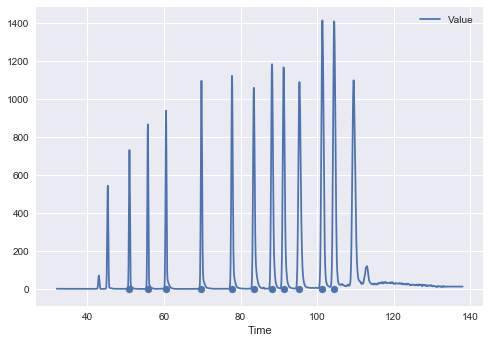

13 13


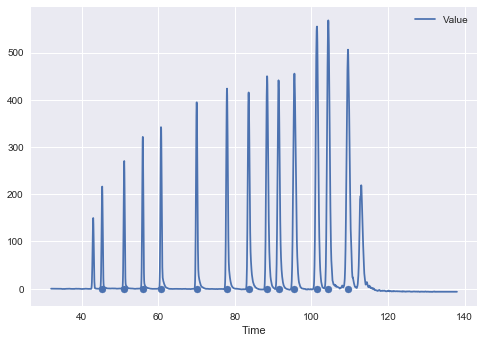

15 13


/Users/zakcostello/anaconda/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/Users/zakcostello/anaconda/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


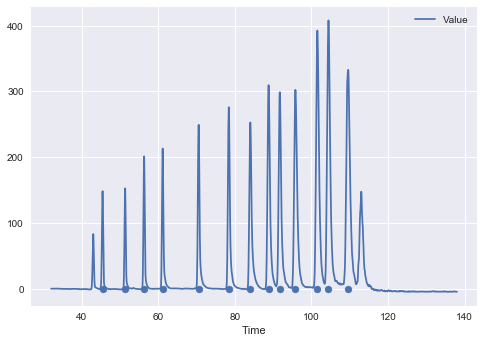

15 13


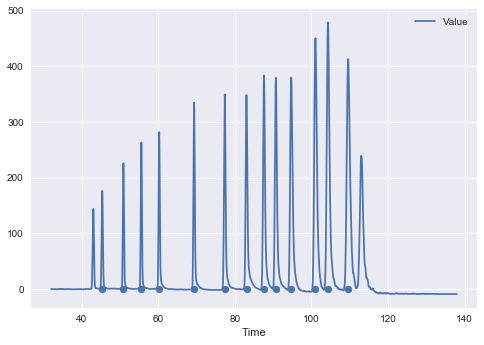

15 13


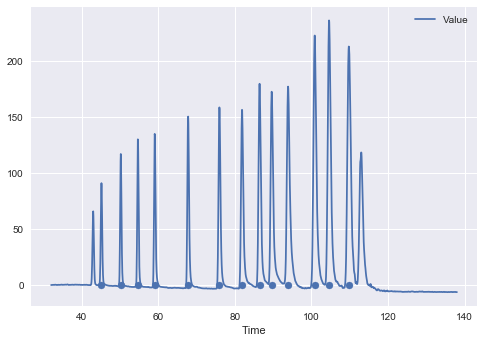

15 13


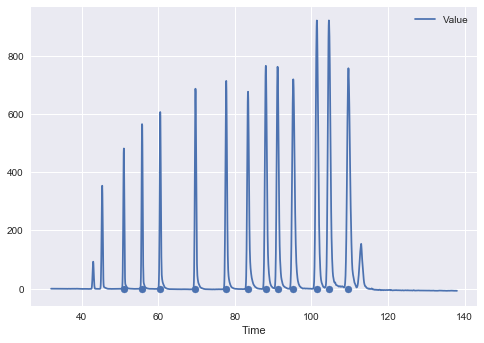

14 13


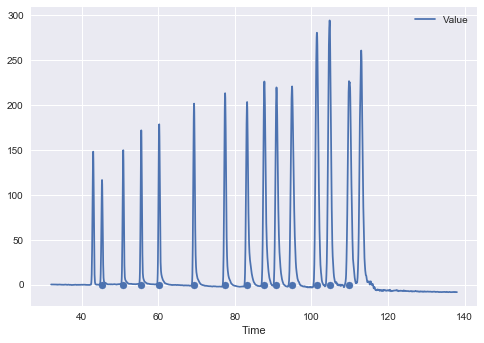

15 13


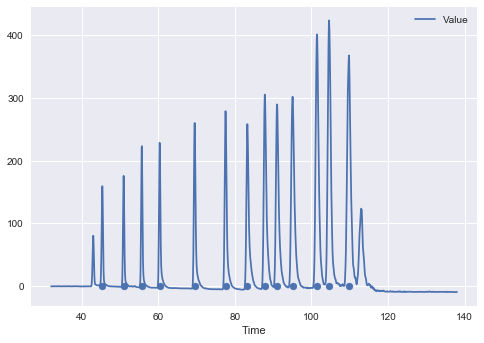

15 13


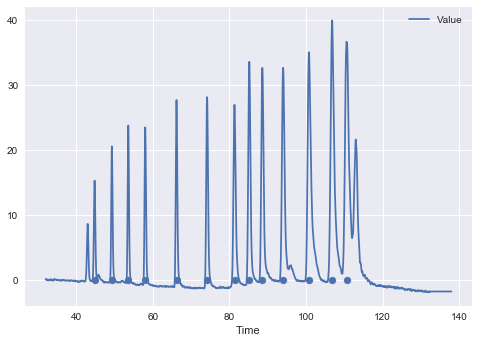

15 13


/Users/zakcostello/anaconda/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


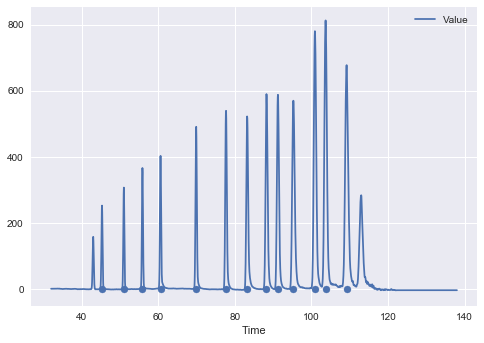

15 13


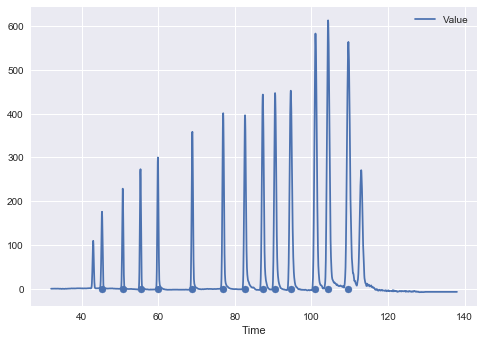

15 13


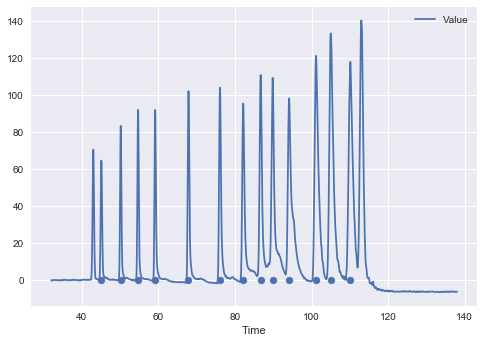

15 13


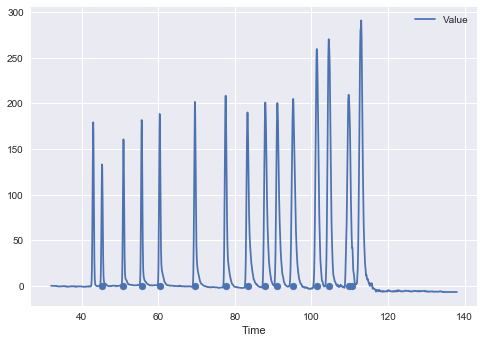

16 13


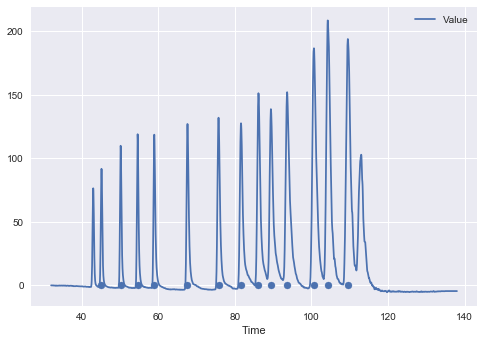

15 13


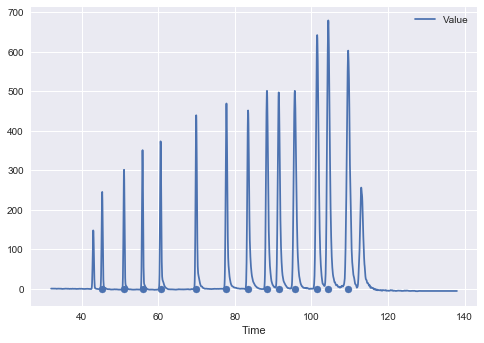

15 13


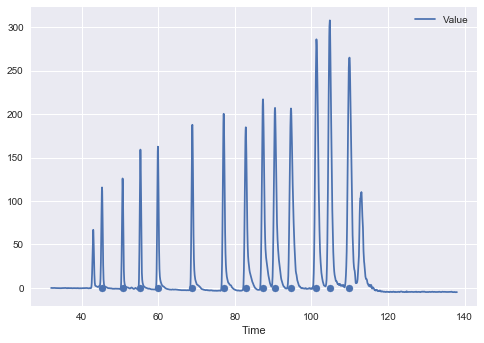

15 13


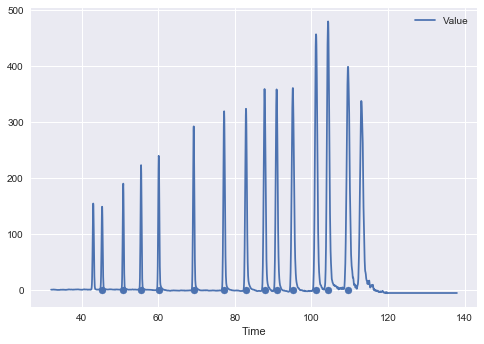

15 13


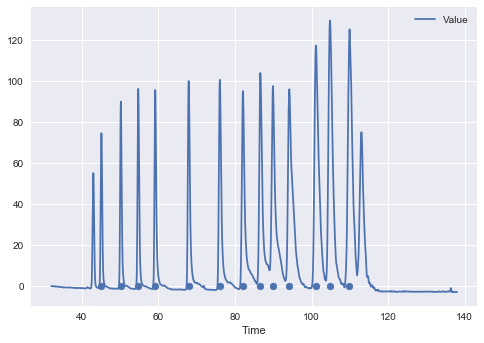

15 13


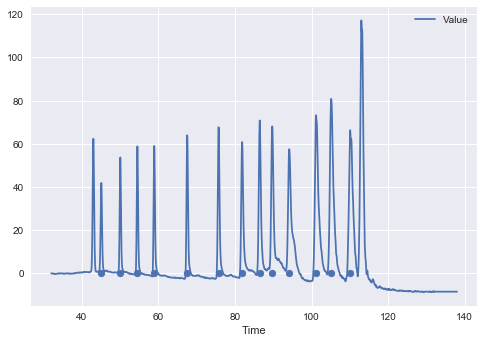

15 13


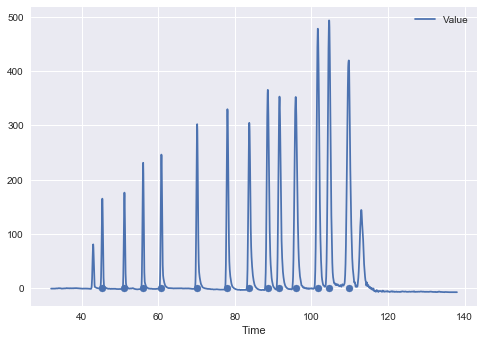

15 13


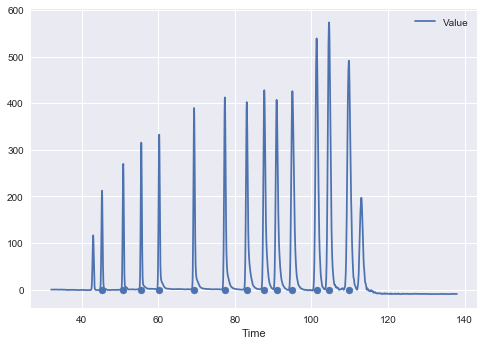

15 13


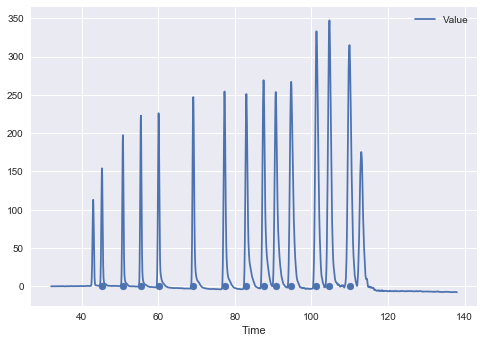

15 13


,Library Loading Concentration,Cluster Density,0,100,200,300,400,500,600,700,...,1000,1100,1200,1300,1400,1500,1600,1700,1800,1900
0,775.0,961.0,-879.487685,-1456.579031,-1567.042015,-1113.224353,1420.166504,4858.441057,9651.040243,13933.791709,...,20181.484128,21747.735161,23271.915827,25733.707651,29843.733321,30282.527272,31255.913332,32958.487777,34735.871333,35687.094286
0,630.0,1335.0,109.910613,-27.749599,-7.835573,303.578775,1108.355250,2036.298144,3218.909457,3984.201987,...,5275.307944,5648.932165,6117.930613,6566.398906,7377.092417,8053.738567,8638.473645,8844.637116,8916.271072,9283.706374
0,1000.0,1305.0,302.736648,67.365588,16.771397,22.951673,298.984245,823.943344,1540.002727,2092.867616,...,3285.519375,3467.667375,3731.101688,3960.622625,4418.457063,4774.336500,5172.475188,5547.749563,6056.699563,6543.638563
0,1100.0,1412.0,36.626367,-132.583335,15.158374,255.525960,924.525224,1782.246274,2709.201848,3426.442898,...,4744.987116,4994.097069,5291.096877,5605.683795,5940.141338,6190.037885,6590.300625,6942.699779,7327.091095,7838.731925
0,1150.0,1703.0,139.961474,-92.196029,-47.155784,1516.547165,1789.537473,2122.339498,2749.526076,3474.643934,...,4718.423593,4927.765558,5245.517621,5599.407185,6159.077743,6446.763172,6872.658197,7463.202498,7911.370944,8549.143204
0,610.0,1271.0,17.504034,-181.061562,-178.132507,488.385726,1874.058187,3312.079500,5171.475488,6637.717428,...,9311.035734,9715.872009,10006.398896,10468.659559,11050.600649,11791.862830,12385.304065,13173.728527,14173.544880,15101.857278
0,1000.0,1640.0,1.286643,-27.757370,-18.317237,27.501155,102.543504,208.578821,322.605355,400.275201,...,586.888943,633.686603,678.671278,716.306944,790.128733,863.922147,921.562887,998.907646,1097.847577,1185.175225
0,1000.0,1521.0,40.854322,-286.593788,-309.891465,175.340542,1516.999752,3178.148800,5505.435174,7722.014630,...,11388.930239,11874.448360,12909.158668,13530.596605,14765.921060,15390.181701,16793.409776,17936.625215,19514.738140,21004.492656
0,950.0,1636.0,121.385137,-3.942208,46.332089,2471.487728,1646.757457,2098.140082,3149.074128,3636.533937,...,5132.847178,5362.281384,5622.877703,5902.668724,6061.204190,6346.993015,6846.617170,7331.361749,7594.798360,8090.859391
0,1000.0,1583.0,113.173035,-60.971702,260.098536,1918.848929,2409.893480,3311.975554,4620.079133,5560.624398,...,6813.060828,7113.131037,7302.718588,7787.918001,8183.358028,8547.920789,9066.408486,9638.603810,9983.007700,10491.343823


,Library Loading Concentration,Cluster Density,0,100,200,300,400,500,600,700,...,1000,1100,1200,1300,1400,1500,1600,1700,1800,1900
Library Loading Concentration,1.000000,0.692352,0.207224,0.111686,0.186387,0.220766,-0.105865,-0.220884,-0.292332,-0.304100,...,-0.285288,-0.279722,-0.273607,-0.270908,-0.270929,-0.289074,-0.282560,-0.274627,-0.260389,-0.243586
Cluster Density,0.692352,1.000000,0.523681,0.527805,0.594832,0.629684,0.093798,-0.198772,-0.335806,-0.406580,...,-0.438670,-0.449601,-0.453603,-0.459532,-0.472759,-0.450628,-0.433771,-0.438219,-0.445712,-0.445850
0,0.207224,0.523681,1.000000,0.963192,0.930607,0.567352,0.064988,-0.250252,-0.464840,-0.586483,...,-0.646112,-0.661765,-0.670966,-0.690010,-0.719207,-0.676115,-0.657083,-0.661866,-0.667915,-0.663706
100,0.111686,0.527805,0.963192,1.000000,0.969949,0.581739,-0.010395,-0.334515,-0.538237,-0.654269,...,-0.723258,-0.741031,-0.750422,-0.765090,-0.785365,-0.731552,-0.713286,-0.722616,-0.738912,-0.746735
200,0.186387,0.594832,0.930607,0.969949,1.000000,0.682038,0.062512,-0.292298,-0.499304,-0.613891,...,-0.684706,-0.700018,-0.710575,-0.723379,-0.744798,-0.690582,-0.670726,-0.678990,-0.695448,-0.702736
300,0.220766,0.629684,0.567352,0.581739,0.682038,1.000000,0.348414,-0.034347,-0.194364,-0.287720,...,-0.340260,-0.348150,-0.359256,-0.367315,-0.391362,-0.361033,-0.346276,-0.345791,-0.356770,-0.358232
400,-0.105865,0.093798,0.064988,-0.010395,0.062512,0.348414,1.000000,0.910090,0.787829,0.675127,...,0.581872,0.563011,0.545102,0.527847,0.488841,0.519397,0.521905,0.516963,0.501578,0.491911
500,-0.220884,-0.198772,-0.250252,-0.334515,-0.292298,-0.034347,0.910090,1.000000,0.959482,0.887996,...,0.819596,0.805684,0.792571,0.779760,0.750215,0.766004,0.761949,0.757565,0.746883,0.737268
600,-0.292332,-0.335806,-0.464840,-0.538237,-0.499304,-0.194364,0.787829,0.959482,1.000000,0.980056,...,0.942531,0.932764,0.924344,0.916902,0.898302,0.906795,0.902150,0.898393,0.889896,0.880017
700,-0.304100,-0.406580,-0.586483,-0.654269,-0.613891,-0.287720,0.675127,0.887996,0.980056,1.000000,...,0.987797,0.982162,0.978188,0.974830,0.965169,0.969254,0.965520,0.963547,0.958202,0.949952


In [4]:
def aproximate_sequence(df,n=100,start=0,stop=15000):
    """Aproximate a discrete sequence using a truncated expansion."""
    
    #Create even spacing
    int_lims = np.linspace(start,stop,n+1)
    
    #Create Interpolation function
    abundance_curve = interp1d(df['base pairs'],df['Value'],fill_value='extrapolate')
    
    #Aproximate Function using an integral
    state = [quad(abundance_curve,a,b)[0] for a,b in zip(int_lims[:-1],int_lims[1:])]
    bps = int_lims[:-1]
    
    return state,bps
    

def find_peaks(df,test=False):
    """Find the peaks of a ladder gel. Return a list of peak times and the 
    base pairs that correspond to those times.
    """
    
    #display(df)
    peaks = peakutils.indexes(df['Value'].values, thres=0.15, min_dist=10)
    #print(peaks)
    #plt.figure(figsize=(10,10))
    #df['Value'].plot()
    #plt.scatter(peaks,np.zeros(len(peaks)))
    #plt.show()
    peak_bps = [35,50,150,300,400,500,600,700,1000,2000,3000,7000,10380]
    peak_times = df['Time'].values[peaks[1:-1]]
    #print(peak_times)
    
    if test:
        plt.figure()
        df.plot('Time','Value')
        plt.scatter(peak_times,np.zeros(len(peak_times)))
        plt.show()
        print(len(peaks),len(peak_bps))
    
    return peak_times,peak_bps

    

def load_data(file_id):
    """load bioanalyzer data from a set of two csvs. Return a pandas series."""
    
    for file in glob.glob(file_id+'*'):
        #Load Ladder Data
        if 'Ladder' in file:
            ladder_df = pd.read_csv(file,skiprows=17)[:-1]
            ladder_df = ladder_df.apply(np.vectorize(float))
            peak_times,peak_bps = find_peaks(ladder_df,test=test)
            #print(peak_times,peak_bps)
            #print(len(peak_times),len(peak_bps))
            time_to_bps = interp1d(peak_times,peak_bps,fill_value='extrapolate',kind='slinear')
            
        #Load Sample Data
        elif 'Sample' in file:
            sample_df = pd.read_csv(file,skiprows=17)[:-2]
            sample_df = sample_df.apply(np.vectorize(float))
            sample_df['base pairs'] = sample_df['Time'].apply(time_to_bps)
        
        #plt.scatter(peak_times,peak_bps)
        #plt.plot(np.arange(0,120),np.vectorize(time_to_bps)(np.arange(0,120)))
        #plt.show()
    
    #Plot Base Pairs Vs Values
    #sample_df.plot('base pairs','Value')
    #plt.show()
    
    #sample_df.plot('Time','Value')
    #plt.show()
    
    #sample_df.plot('Time','base pairs')
    #plt.show()

    state,bps = aproximate_sequence(sample_df,n=20,stop=2000)    
    
    #Create df
    columns = ['Library Loading Concentration','Cluster Density'] + [str(int(bp)) for bp in bps]
    data = [[sample_df['Library Loading Concentration (pM)'].values[0]*100,sample_df['Cluster Density (K/mm^2)'].values[0]] + state]
    
    #print(len(data),data)
    #print(len(columns),columns)
    state_df = pd.DataFrame(data,columns=columns)
    #display(state_df)
    
    return state_df
    
    
df = None
for file_id in unique_file_ids: 
    try:
        state_df = load_data(file_id)
        if df is None:
            df = state_df
        else:
            df = df.append(state_df)

        #display(df)
        #Merge Series Into Data Frame
    except:
        pass
display(df)
display(df.corr(method='pearson', min_periods=1))


# Fit and Evaluate Machine Learning Models

In [39]:
#Find & Fit Model
X = df.loc[:,df.columns != 'Cluster Density']
y = df['Cluster Density']
tpot = TPOTRegressor(generations=5, population_size=20, verbosity=2)
model = tpot.fit(X, y).fitted_pipeline_
#model = RandomForestRegressor().fit(X,y)

#print(list(X.columns))
#display(model.feature_importances_)
#feature_df = pd.DataFrame(data=list(zip(list(X.columns),model.feature_importances_)),columns=['Feature','Importance']).set_index('Feature').sort_values('Importance',ascending=False)
#display(feature_df)

Version 0.9.2 of tpot is outdated. Version 0.9.3 was released Monday April 09, 2018.


Optimization Progress:  33%|███▎      | 40/120 [00:07<00:18,  4.31pipeline/s]

Generation 1 - Current best internal CV score: -40478.53310185185


Optimization Progress:  50%|█████     | 60/120 [00:17<00:26,  2.23pipeline/s]

Generation 2 - Current best internal CV score: -26749.096134929656


Optimization Progress:  67%|██████▋   | 80/120 [00:24<00:16,  2.44pipeline/s]

Generation 3 - Current best internal CV score: -26749.096134929656


Optimization Progress:  83%|████████▎ | 100/120 [00:31<00:04,  4.01pipeline/s]

Generation 4 - Current best internal CV score: -26749.096134929656


Generation 5 - Current best internal CV score: -26749.096134929656

Best pipeline: LassoLarsCV(FeatureAgglomeration(StandardScaler(input_matrix), affinity=euclidean, linkage=ward), normalize=False)


961.0 1703.0 742.0


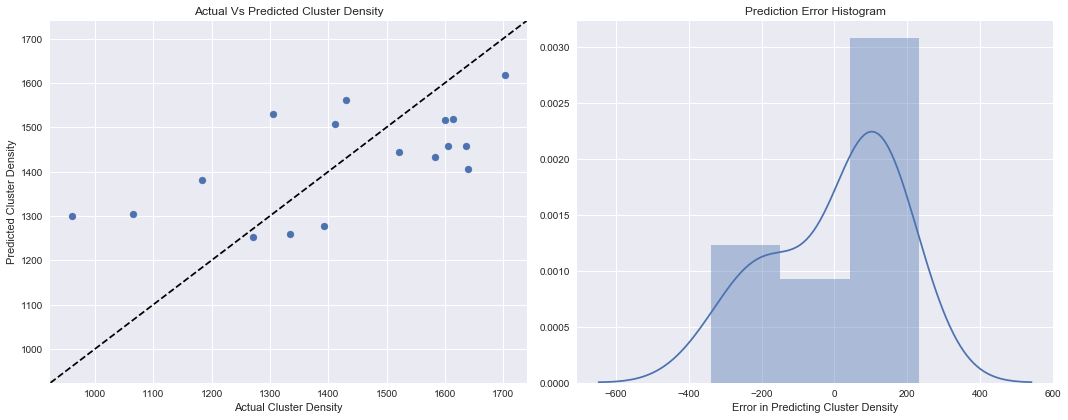

In [35]:
#Plot Cross Validated Predictions
y_p = cross_val_predict(model,X,y)

plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.scatter(y,y_p)
axes = plt.gca()
ymin, ymax = axes.get_ylim()
xmin, xmax = axes.get_xlim()
min_val = min(xmin,ymin)
max_val = max(ymax,xmax)
plt.plot([min_val,max_val],[min_val,max_val],'k--')
plt.xlim([min_val,max_val])
plt.ylim([min_val,max_val])
plt.title('Actual Vs Predicted Cluster Density')
plt.xlabel('Actual Cluster Density')
plt.ylabel('Predicted Cluster Density')

plt.subplot(1,2,2)
y_err = [ye -ye_p for ye,ye_p in zip(y,y_p)]
print(min(y),max(y),max(y)-min(y))
sns.distplot(y_err)
plt.title('Prediction Error Histogram (Mean Error: {})'.format())
plt.xlabel('Error in Predicting Cluster Density')

plt.tight_layout()
plt.show()



,Library Loading Concentration,Cluster Density,0,100,200,300,400,500,600,700,...,1000,1100,1200,1300,1400,1500,1600,1700,1800,1900
0,775.0,961.0,-879.487685,-1456.579031,-1567.042015,-1113.224353,1420.166504,4858.441057,9651.040243,13933.791709,...,20181.484128,21747.735161,23271.915827,25733.707651,29843.733321,30282.527272,31255.913332,32958.487777,34735.871333,35687.094286
0,630.0,1335.0,109.910613,-27.749599,-7.835573,303.578775,1108.355250,2036.298144,3218.909457,3984.201987,...,5275.307944,5648.932165,6117.930613,6566.398906,7377.092417,8053.738567,8638.473645,8844.637116,8916.271072,9283.706374
0,1000.0,1305.0,302.736648,67.365588,16.771397,22.951673,298.984245,823.943344,1540.002727,2092.867616,...,3285.519375,3467.667375,3731.101688,3960.622625,4418.457063,4774.336500,5172.475188,5547.749563,6056.699563,6543.638563
0,1100.0,1412.0,36.626367,-132.583335,15.158374,255.525960,924.525224,1782.246274,2709.201848,3426.442898,...,4744.987116,4994.097069,5291.096877,5605.683795,5940.141338,6190.037885,6590.300625,6942.699779,7327.091095,7838.731925
0,1150.0,1703.0,139.961474,-92.196029,-47.155784,1516.547165,1789.537473,2122.339498,2749.526076,3474.643934,...,4718.423593,4927.765558,5245.517621,5599.407185,6159.077743,6446.763172,6872.658197,7463.202498,7911.370944,8549.143204
0,610.0,1271.0,17.504034,-181.061562,-178.132507,488.385726,1874.058187,3312.079500,5171.475488,6637.717428,...,9311.035734,9715.872009,10006.398896,10468.659559,11050.600649,11791.862830,12385.304065,13173.728527,14173.544880,15101.857278
0,1000.0,1640.0,1.286643,-27.757370,-18.317237,27.501155,102.543504,208.578821,322.605355,400.275201,...,586.888943,633.686603,678.671278,716.306944,790.128733,863.922147,921.562887,998.907646,1097.847577,1185.175225
0,1000.0,1521.0,40.854322,-286.593788,-309.891465,175.340542,1516.999752,3178.148800,5505.435174,7722.014630,...,11388.930239,11874.448360,12909.158668,13530.596605,14765.921060,15390.181701,16793.409776,17936.625215,19514.738140,21004.492656
0,950.0,1636.0,121.385137,-3.942208,46.332089,2471.487728,1646.757457,2098.140082,3149.074128,3636.533937,...,5132.847178,5362.281384,5622.877703,5902.668724,6061.204190,6346.993015,6846.617170,7331.361749,7594.798360,8090.859391
0,1000.0,1583.0,113.173035,-60.971702,260.098536,1918.848929,2409.893480,3311.975554,4620.079133,5560.624398,...,6813.060828,7113.131037,7302.718588,7787.918001,8183.358028,8547.920789,9066.408486,9638.603810,9983.007700,10491.343823


500.0 1150.0


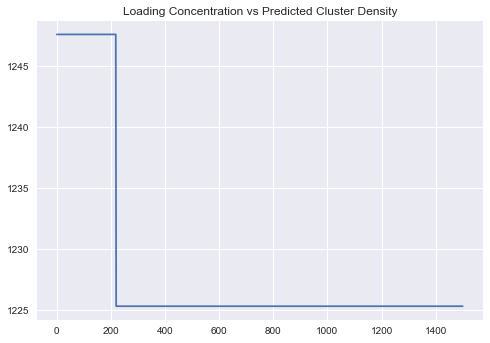

In [38]:
def predict_loading_concentration(spectra,model,low=0,high=1500,n=1000):
    cluster_densities = []
    loading_concentrations = np.linspace(low,high,n)
    for lc in loading_concentrations:
        X = np.append(spectra,lc*100).reshape(1,-1)
        y = model.predict(X)
        cluster_densities.append(y[0])
        
    #print(cluster_densities)
    plt.plot(loading_concentrations,cluster_densities)
    plt.title('Loading Concentration vs Predicted Cluster Density')
    plt.show()
    
display(df)

print(min(df['Library Loading Concentration']),max(df['Library Loading Concentration']))
columns = [column for column in df.columns if not column in ['Cluster Density','Library Loading Concentration'] ]
spectra = df[columns].iloc[0].values
#plt.plot(spectra)
#plt.show()

predict_loading_concentration(spectra,model)